In [ ]:
!unzip data.zip

In [25]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [26]:
# ## 2. Data Loading and Initial Exploration
try:
    # 데이터 파일명이 다를 경우 수정해주세요.
    df = pd.read_csv("/content/data/voice.csv")
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'voice.csv' not found. Please check the file path.")
    df = pd.DataFrame()

if not df.empty:
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Info:")
    df.info()

Dataset loaded successfully.
Dataset shape: (3168, 21)

First 5 rows of the dataset:
   meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meand

In [27]:
# ## 3. Data Preprocessing
if not df.empty:
    # 타겟 변수인 'label'을 수치형으로 변환 (female: 0, male: 1)
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])
    print("\nLabel mapping:", {i: label for i, label in enumerate(le.classes_)})


Label mapping: {0: 'female', 1: 'male'}


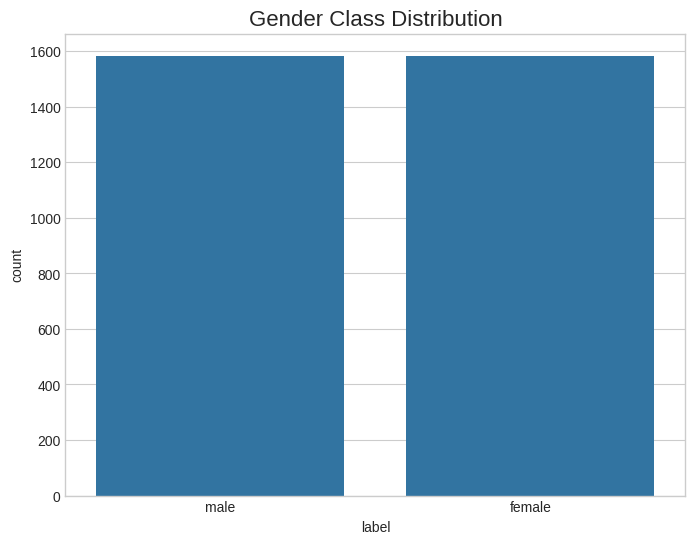

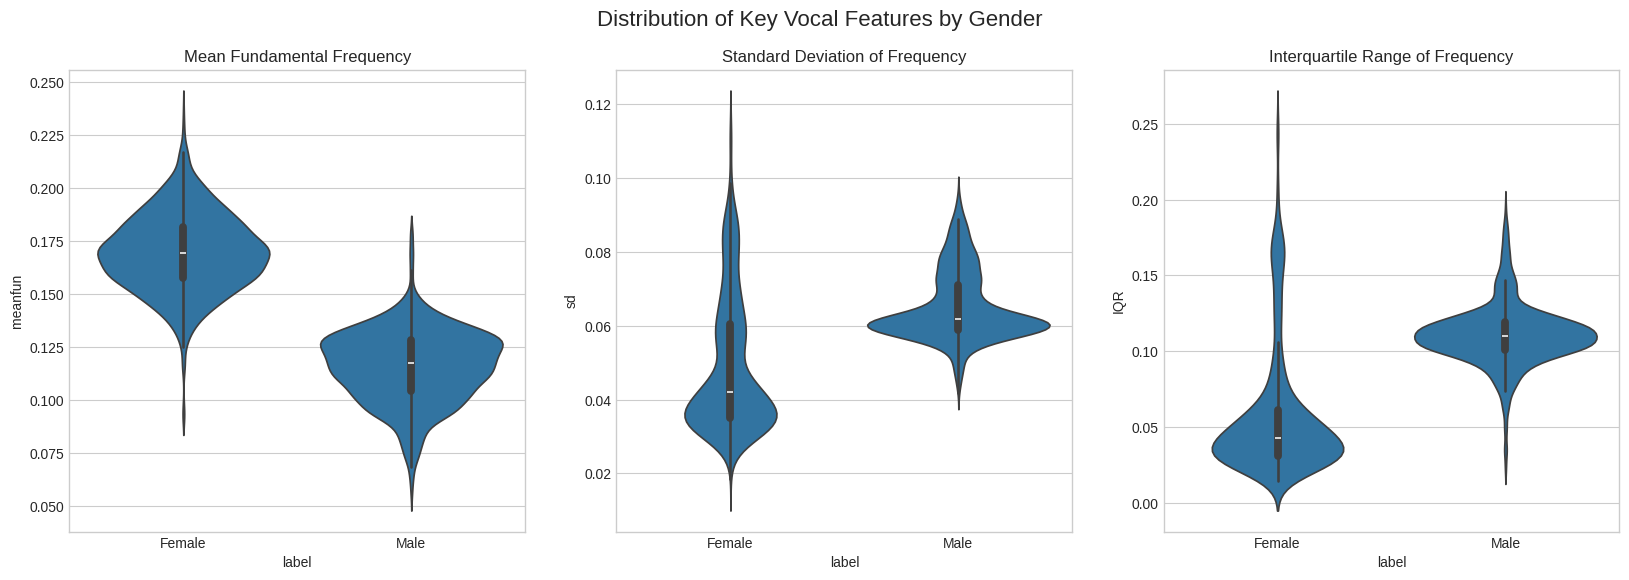

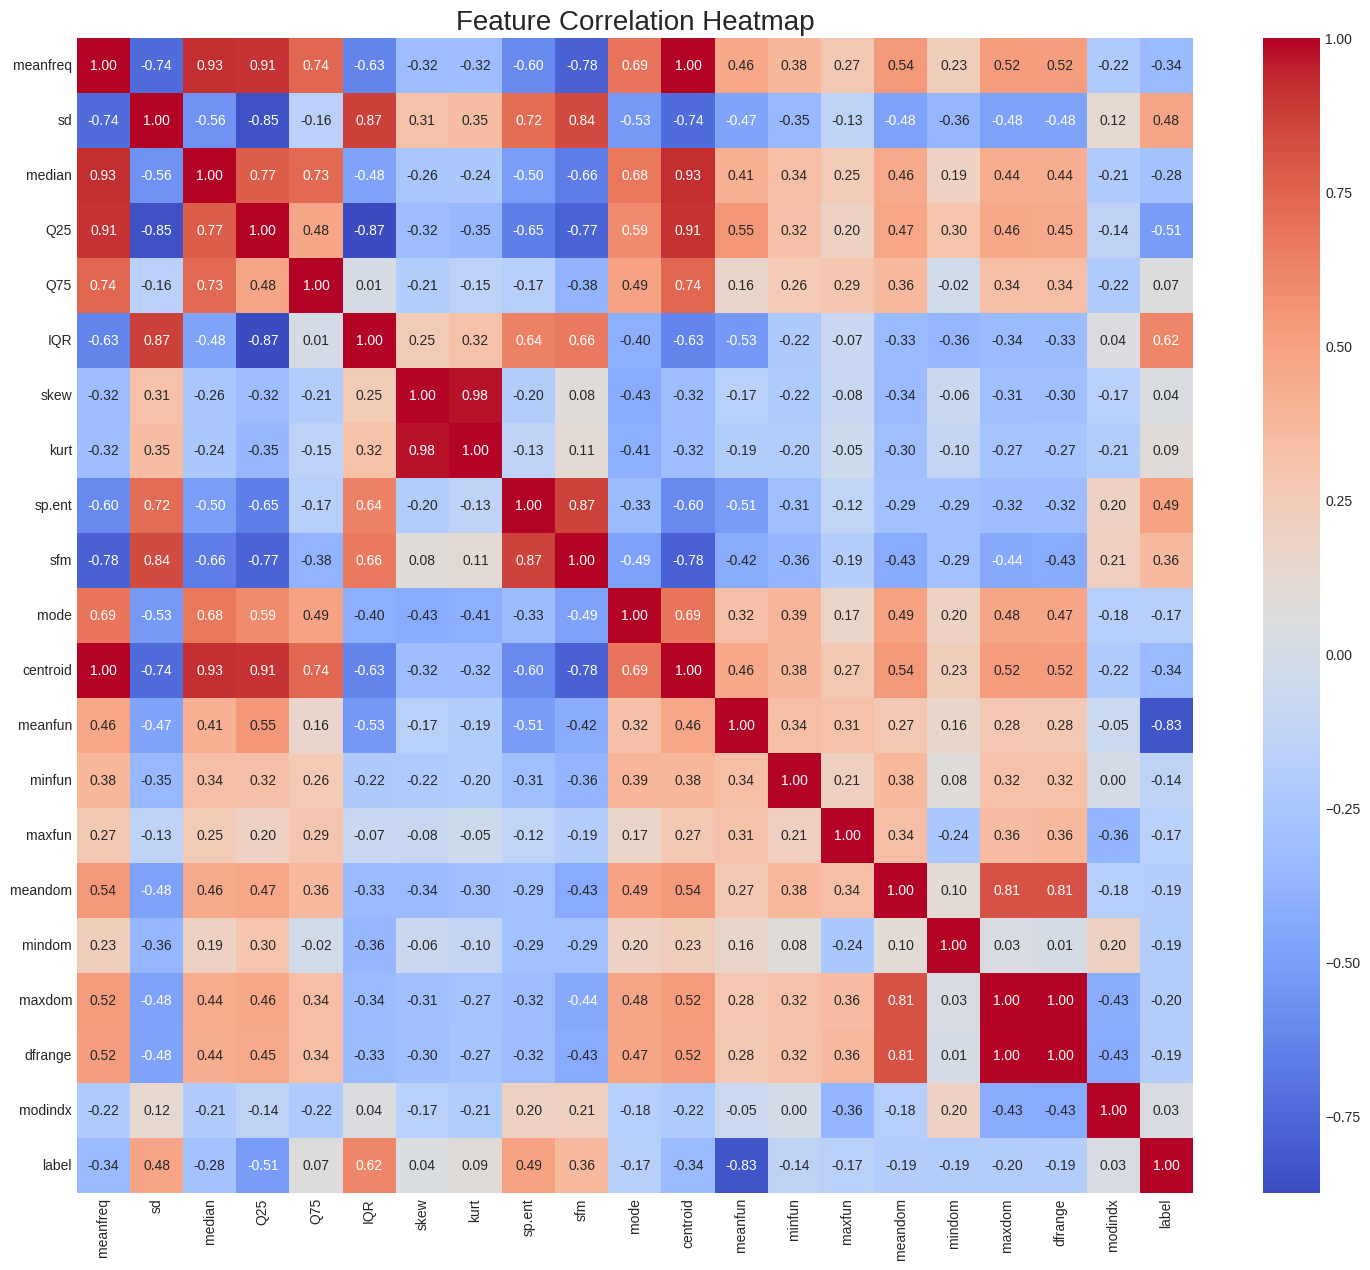

In [28]:
# ## 4. Exploratory Data Analysis (EDA)
if not df.empty:
    # 클래스 분포 확인
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=df['label'].map({0:'female', 1:'male'}))
    plt.title('Gender Class Distribution', fontsize=16)
    plt.show()

    # 주요 특성 분포 비교 시각화 (성별에 따라)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Distribution of Key Vocal Features by Gender', fontsize=16)

    sns.violinplot(ax=axes[0], data=df, x='label', y='meanfun')
    axes[0].set_title('Mean Fundamental Frequency')
    axes[0].set_xticklabels(['Female', 'Male'])

    sns.violinplot(ax=axes[1], data=df, x='label', y='sd')
    axes[1].set_title('Standard Deviation of Frequency')
    axes[1].set_xticklabels(['Female', 'Male'])

    sns.violinplot(ax=axes[2], data=df, x='label', y='IQR')
    axes[2].set_title('Interquartile Range of Frequency')
    axes[2].set_xticklabels(['Female', 'Male'])
    plt.show()

    # 전체 특성 간 상관관계 히트맵
    plt.figure(figsize=(18, 15))
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap', fontsize=20)
    plt.show()


In [29]:
# ## 5. Model Training and Comparison
if not df.empty:
    X = df.drop('label', axis=1)
    y = df['label']

    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 데이터 스케일링
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")

    models = {
        "Logistic Regression": LogisticRegression(random_state=42),
        "Support Vector Machine": SVC(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    }

    results = {}

    for name, model in models.items():
        print(f"\n--- Training {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)['1'] # '1'은 male 클래스

        results[name] = {
            'Accuracy': accuracy,
            'Precision': report['precision'],
            'Recall': report['recall'],
            'F1-Score': report['f1-score']
        }

    results_df = pd.DataFrame(results).T
    print("\n--- Model Performance Comparison ---")
    print(results_df.sort_values(by='F1-Score', ascending=False))


Training data shape: (2534, 20)
Test data shape: (634, 20)

--- Training Logistic Regression ---

--- Training Support Vector Machine ---

--- Training Random Forest ---

--- Training XGBoost ---

--- Model Performance Comparison ---
                        Accuracy  Precision    Recall  F1-Score
XGBoost                 0.987382   0.984326  0.990536  0.987421
Random Forest           0.984227   0.981191  0.987382  0.984277
Support Vector Machine  0.982650   0.978125  0.987382  0.982732
Logistic Regression     0.974763   0.965944  0.984227  0.975000



--- Detailed Analysis of Best Model: XGBoost ---


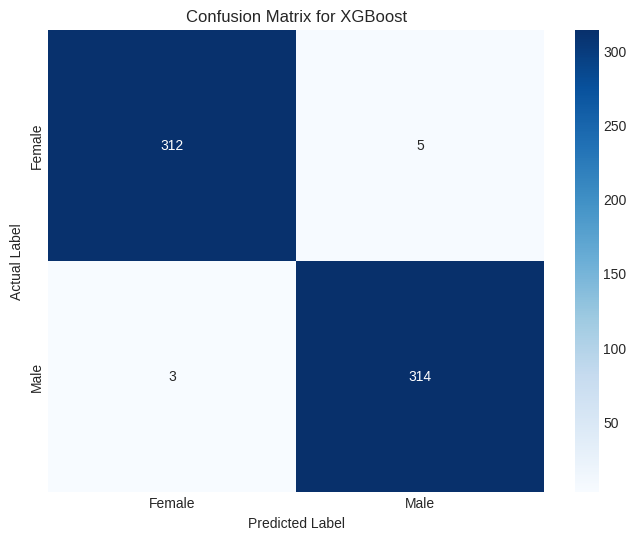


Classification Report for XGBoost
              precision    recall  f1-score   support

      Female       0.99      0.98      0.99       317
        Male       0.98      0.99      0.99       317

    accuracy                           0.99       634
   macro avg       0.99      0.99      0.99       634
weighted avg       0.99      0.99      0.99       634



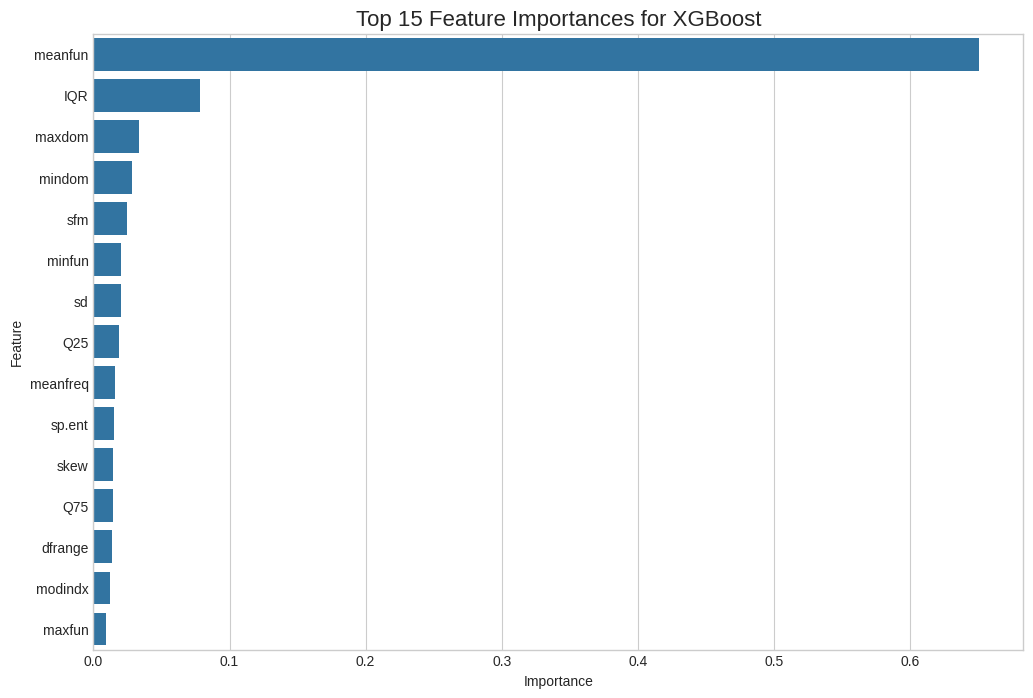

In [30]:
# ## 6. Results Analysis
if not df.empty:
    best_model_name = results_df['F1-Score'].idxmax()
    best_model = models[best_model_name]
    print(f"\n--- Detailed Analysis of Best Model: {best_model_name} ---")

    y_pred_best = best_model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print(f'\nClassification Report for {best_model_name}')
    print(classification_report(y_test, y_pred_best, target_names=['Female', 'Male']))

    # 특성 중요도 분석 (Tree-based 모델인 경우)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15)) # 상위 15개 특성
        plt.title(f'Top 15 Feature Importances for {best_model_name}', fontsize=16)
        plt.show()